In [ ]:
# # SVM 调制识别模型训练与评估 (使用 utils) - RAPIDS cuML
#
# 使用预处理特征训练 cuML SVM 模型，并调用 utils 进行评估和绘图。

# ## 1. 导入库与环境设置

# +
# 基础库
import numpy as np
import cupy as cp
import pickle
import time
import os
import gc
import matplotlib.pyplot as plt # 仍然需要 plt 来显示图形
# import itertools # 用于生成参数组合

# RAPIDS cuML
from cuml.svm import SVC
from cuml.metrics import accuracy_score as cuml_acc_score # 区分 sklearn 的
print("RAPIDS cuML 库导入成功。")

# Scikit-learn (用于加载 scaler 和 ConfusionMatrixDisplay)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
print("Scikit-learn 辅助库导入成功。")

# 导入自定义工具函数
import evaluation_utils
import plotting_utils
print("自定义工具函数导入成功。")

# 检查库版本 (可选)
import cuml
import sklearn
print(f"RAPIDS cuML 版本: {cuml.__version__}")
print(f"Scikit-learn 版本: {sklearn.__version__}")

# 设置字体参数 (供 plotting_utils 使用)
FONT_FILENAME = "NotoSansSC-VariableFont_wght.ttf"
FONT_SUBDIR = "fonts"
MODEL_NAME = "cuML SVM" # 用于图表标题

# 确保负号显示
plt.rcParams['axes.unicode_minus'] = False
# -

RAPIDS cuML 库导入成功。
Scikit-learn 辅助库导入成功。
自定义工具函数导入成功。
RAPIDS cuML 版本: 25.04.00
Scikit-learn 版本: 1.6.1


In [ ]:
# ## 2. 加载预处理数据

# +
data_dir = 'processed_ml_features' # 使用预处理步骤中指定的目录名
print(f"从 '{data_dir}' 加载数据...")

try:
    X_train_scaled_np = np.load(os.path.join(data_dir, 'X_train_scaled.npy'))
    X_val_scaled_np = np.load(os.path.join(data_dir, 'X_val_scaled.npy'))
    X_test_scaled_np = np.load(os.path.join(data_dir, 'X_test_scaled.npy'))
    y_train_np = np.load(os.path.join(data_dir, 'y_train.npy'))
    y_val_np = np.load(os.path.join(data_dir, 'y_val.npy'))
    y_test_np = np.load(os.path.join(data_dir, 'y_test.npy'))
    snr_test_np = np.load(os.path.join(data_dir, 'snr_test.npy'))
    label_mapping = np.load(os.path.join(data_dir, 'label_mapping.npy'), allow_pickle=True).item()
    scaler_path = os.path.join(data_dir, 'scaler.pkl')
    with open(scaler_path, 'rb') as f: scaler = pickle.load(f)

    # 提取调制类型列表和类别标签 (整数)
    mods = list(label_mapping.values())
    num_classes = len(mods)
    labels = np.arange(num_classes) # 用于评估和绘图

    print("NumPy 数据加载完成。")
    print(f"测试集形状: X={X_test_scaled_np.shape}, y={y_test_np.shape}, snr={snr_test_np.shape}")
    print(f"调制类型 ({num_classes}): {mods}")

    # --- 将需要的数据传输到 GPU (转换为 CuPy 数组) ---
    print("\n将数据转换为 CuPy 数组 (传输到 GPU)...")
    X_train_scaled = cp.asarray(X_train_scaled_np); del X_train_scaled_np # 训练特征
    X_val_scaled = cp.asarray(X_val_scaled_np);     del X_val_scaled_np   # 验证特征
    X_test_scaled = cp.asarray(X_test_scaled_np)    # 测试集保留 CuPy
    y_train = cp.asarray(y_train_np);               del y_train_np        # 训练标签
    y_val = cp.asarray(y_val_np);                   del y_val_np          # 验证标签

    # y_test 和 snr_test 暂时保留 NumPy 版本，评估函数需要 NumPy 输入
    y_test = y_test_np
    snr_test = snr_test_np

    gc.collect() # 清理内存
    print("数据传输到 GPU 并清理 NumPy 完成。")

except FileNotFoundError as e:
    print(f"错误：加载数据失败，找不到文件: {e.filename}")
    print(f"请确保在 '{data_dir}' 目录下已生成预处理文件。")
    raise e
# -

从 'processed_ml_features' 加载数据...
NumPy 数据加载完成。
测试集形状: X=(44000, 16), y=(44000,), snr=(44000,)
调制类型 (11): [np.str_('8PSK'), np.str_('AM-DSB'), np.str_('AM-SSB'), np.str_('BPSK'), np.str_('CPFSK'), np.str_('GFSK'), np.str_('PAM4'), np.str_('QAM16'), np.str_('QAM64'), np.str_('QPSK'), np.str_('WBFM')]

将数据转换为 CuPy 数组 (传输到 GPU)...
数据传输到 GPU 并清理 NumPy 完成。


In [3]:

# # ## 3. 超参数网格搜索 (在验证集上评估)

# # +
# # 定义要搜索的超参数网格
# # 注意：更大的网格会显著增加搜索时间
# param_grid = {
#     'C': [1, 10, 50],           # 正则化参数
#     'gamma': [0.1, 1, 'scale'], # RBF 核系数 ('scale' 是常用默认值)
#     'kernel': ['rbf']           # 固定使用 RBF 核进行搜索
#     # 可以添加 'degree' (如果用 'poly'), 'coef0' 等其他参数
# }

# # 生成所有参数组合
# keys, values = zip(*param_grid.items())
# param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

# print(f"开始网格搜索，共 {len(param_combinations)} 种参数组合...")

# best_score = -1
# best_params = None
# search_results = []

# start_search_time = time.time()

# # 迭代搜索
# for i, params in enumerate(param_combinations):
#     print(f"\n[{i+1}/{len(param_combinations)}] 尝试参数: {params}")
#     iter_start_time = time.time()
#     try:
#         # 1. 使用当前参数组合在训练集上训练模型
#         svm_model = SVC(**params)
#         svm_model.fit(X_train_scaled, y_train) # 在训练集上训练

#         # 2. 在验证集上进行预测 (GPU -> GPU)
#         y_val_pred = svm_model.predict(X_val_scaled)

#         # 3. 在验证集上计算准确率 (使用 cuML metric，GPU -> scalar)
#         # cuml_acc_score 可以直接处理 CuPy 数组
#         score = cuml_acc_score(y_val, y_val_pred)
#         iter_end_time = time.time()
#         print(f"  验证集准确率: {score:.4f} (耗时: {iter_end_time - iter_start_time:.2f} 秒)")

#         search_results.append({'params': params, 'score': score})

#         # 4. 更新最佳分数和最佳参数
#         if score > best_score:
#             best_score = score
#             best_params = params
#             print(f"  *** 找到新的最佳分数: {best_score:.4f} ***")

#         # 清理当前迭代的模型和预测，释放 GPU 内存
#         del svm_model, y_val_pred
#         gc.collect()
#         cp.get_default_memory_pool().free_all_blocks()

#     except Exception as e:
#         iter_end_time = time.time()
#         print(f"  参数 {params} 训练/评估出错: {e} (耗时: {iter_end_time - iter_start_time:.2f} 秒)")
#         search_results.append({'params': params, 'score': -1, 'error': str(e)})

# end_search_time = time.time()
# print(f"\n网格搜索完成。总耗时: {end_search_time - start_search_time:.2f} 秒")

# if best_params:
#     print(f"\n找到的最佳参数: {best_params}")
#     print(f"对应的最佳验证集准确率: {best_score:.4f}")
# else:
#     print("\n错误：未能找到有效的最佳参数组合。")
#     # 可以根据需要抛出错误或设置默认参数
#     # best_params = {'C': 10, 'kernel': 'rbf', 'gamma': 'scale'} # 设置回默认值以继续
#     raise ValueError("网格搜索未能找到最佳参数")

# 最佳参数组合为{'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}

In [4]:
# ## 3. SVM 模型参数定义

# +
manual_params = {'C': 50, 'gamma': 'scale', 'kernel': 'rbf', } # 最佳参数组合
print("将使用的 SVM 参数:")
print(manual_params)
# -

将使用的 SVM 参数:
{'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
# ## 4. 模型训练
# 使用网格搜索找到的最佳超参数，在合并后的训练集和验证集上训练最终模型。

# +
# 合并训练集和验证集 (在 GPU 上操作) - 确保在搜索后执行此操作
print("\n合并训练集和验证集用于最终模型训练 (GPU)...\n")
X_train_full_cp = cp.vstack((X_train_scaled, X_val_scaled))
y_train_full_cp = cp.concatenate((y_train, y_val))
print(f"合并后的 GPU 训练数据形状 (CuPy): X={X_train_full_cp.shape}, y={y_train_full_cp.shape}")

# 清理单独的训练/验证集 GPU 内存
del X_train_scaled, X_val_scaled, y_train, y_val
gc.collect()
cp.get_default_memory_pool().free_all_blocks()


# --- 使用找到的最佳参数训练最终模型 ---
print(f"\n使用找到的最佳参数 {manual_params} 开始训练最终 cuML SVC 模型...\n")
best_svm_model = None # 初始化最终模型变量
start_time = time.time()
try:
    final_svm_model = SVC(**manual_params) # 使用 manual_params
    final_svm_model.fit(X_train_full_cp, y_train_full_cp) # 在合并数据上训练
    end_time = time.time()
    training_duration = end_time - start_time
    print(f"\n最终模型训练完成。耗时: {training_duration:.2f} 秒")
    best_svm_model = final_svm_model # 将训练好的模型赋给 best_svm_model 供后续使用

except Exception as e:
    print(f"\n错误：训练最终 cuML SVC 模型失败: {e}")

# 清理合并后的训练数据内存
del X_train_full_cp, y_train_full_cp
gc.collect()
cp.get_default_memory_pool().free_all_blocks()

if best_svm_model:
    print(f"\n成功训练了最终 cuML SVM 模型: {best_svm_model}")
else:
    print("\n警告：最终模型未能成功训练。后续评估将无法进行。")
# -


合并训练集和验证集用于最终模型训练 (GPU)...

合并后的 GPU 训练数据形状 (CuPy): X=(176000, 16), y=(176000,)

使用找到的最佳参数 {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'} 开始训练最终 cuML SVC 模型...


最终模型训练完成。耗时: 79.55 秒

成功训练了最终 cuML SVM 模型: SVC()


In [ ]:
# ## 5. 测试集评估 - 预测
# 使用训练好的最佳 SVM 模型在测试集上进行预测。

# +
all_preds_np = None # 初始化预测结果变量
if best_svm_model: # 检查模型是否已成功训练
    print("\n在 GPU 测试集上进行预测...")
    start_time = time.time()
    try:
        # 使用 cuML 模型在 GPU 上预测 (输入为 CuPy 数组)
        all_preds_cp = best_svm_model.predict(X_test_scaled) # 预测得到 CuPy 数组
        end_time = time.time()
        print(f"GPU 预测完成。耗时: {end_time - start_time:.2f} 秒")

        # --- 将预测结果转为 NumPy 供评估函数使用 ---
        # 因为后续的 evaluation_utils 和 plotting_utils 函数需要 NumPy 数组
        print("将预测结果从 CuPy 转换为 NumPy...")
        all_preds_np = cp.asnumpy(all_preds_cp)

        # 清理 GPU 上的预测结果数组
        del all_preds_cp
        gc.collect()
        cp.get_default_memory_pool().free_all_blocks()
        print("转换完成。")

        # 验证形状 (y_test 是 NumPy)
        assert len(all_preds_np) == len(y_test), "预测结果和真实标签长度不一致!"
        print(f"预测标签形状 (NumPy): {all_preds_np.shape}")
        print(f"真实标签形状 (NumPy): {y_test.shape}")

    except Exception as e:
        print(f"预测过程中发生错误: {e}")
else:
    print("\n错误：模型未成功训练，无法进行预测。")
# -


在 GPU 测试集上进行预测...
GPU 预测完成。耗时: 9.03 秒
将预测结果从 CuPy 转换为 NumPy...
转换完成。
预测标签形状 (NumPy): (44000,)
真实标签形状 (NumPy): (44000,)


In [ ]:
# ## 6. 计算整体性能指标 (调用 utils)
# 使用 evaluation_utils 中的函数计算整体准确率、分类报告和混淆矩阵。

# +
if all_preds_np is not None:
    # 调用工具函数计算指标
    # 确认 y_test (真实标签) 和 all_preds_np (预测标签) 都是 NumPy 数组
    # mods 是从 label_mapping 获取的调制类型名称列表
    # labels 是对应的整数标签 [0, 1, ..., num_classes-1]
    print("\n计算整体性能指标...")
    overall_accuracy, report, conf_matrix_overall_np = evaluation_utils.calculate_metrics(
        y_test, all_preds_np, mods, labels=labels
    )
    # 这些指标已在 calculate_metrics 函数内部打印输出
else:
    print("\n错误：预测结果无效，无法计算性能指标。")
# -


计算整体性能指标...
整体准确率 (Overall Accuracy): 0.5303

计算分类报告...

分类报告 (Classification Report):

              precision    recall  f1-score   support

        8PSK     0.6493    0.4055    0.4992      4000
      AM-DSB     0.5735    0.6320    0.6013      4000
      AM-SSB     0.2490    0.9720    0.3965      4000
        BPSK     0.8201    0.5723    0.6741      4000
       CPFSK     0.7915    0.5420    0.6434      4000
        GFSK     0.8098    0.5633    0.6644      4000
        PAM4     0.9097    0.6395    0.7510      4000
       QAM16     0.5109    0.3468    0.4131      4000
       QAM64     0.5938    0.4667    0.5227      4000
        QPSK     0.6397    0.4540    0.5311      4000
        WBFM     0.5759    0.2390    0.3378      4000

    accuracy                         0.5303     44000
   macro avg     0.6476    0.5303    0.5486     44000
weighted avg     0.6476    0.5303    0.5486     44000


计算整体混淆矩阵 (使用 scikit-learn)...

整体混淆矩阵 (NumPy 数组):

[[1622   11 1444   46  149   36    8  120   76

In [ ]:
# ## 7. 按 SNR 计算性能指标 (调用 utils)
# 使用 evaluation_utils 中的函数计算每个 SNR 下的准确率和混淆矩阵。

# +
if all_preds_np is not None:
    # 调用工具函数计算 SNR 指标
    # y_test, all_preds_np, snr_test 都为 NumPy 数组
    print("\n按 SNR 计算性能指标...")
    snr_accuracy_dict, snr_conf_matrix_np_dict = evaluation_utils.calculate_snr_metrics(
        y_test, all_preds_np, snr_test, labels=labels
    )
    # 将准确率转换为百分比
    snr_acc_percent = {snr: acc * 100 for snr, acc in snr_accuracy_dict.items()}
    # 各 SNR 指标已在 calculate_snr_metrics 函数内部打印输出
else:
    print("\n错误：预测结果无效，无法按 SNR 计算性能指标。")
# -


按 SNR 计算性能指标...
测试集中的 SNR 值: [np.int64(-20), np.int64(-18), np.int64(-16), np.int64(-14), np.int64(-12), np.int64(-10), np.int64(-8), np.int64(-6), np.int64(-4), np.int64(-2), np.int64(0), np.int64(2), np.int64(4), np.int64(6), np.int64(8), np.int64(10), np.int64(12), np.int64(14), np.int64(16), np.int64(18)]
SNR = -20 dB: Accuracy = 0.1036, Samples = 2191
SNR = -18 dB: Accuracy = 0.0953, Samples = 2213
SNR = -16 dB: Accuracy = 0.0950, Samples = 2210
SNR = -14 dB: Accuracy = 0.1078, Samples = 2199
SNR = -12 dB: Accuracy = 0.1100, Samples = 2173
SNR = -10 dB: Accuracy = 0.1650, Samples = 2139
SNR =  -8 dB: Accuracy = 0.2736, Samples = 2186
SNR =  -6 dB: Accuracy = 0.3951, Samples = 2207
SNR =  -4 dB: Accuracy = 0.5256, Samples = 2228
SNR =  -2 dB: Accuracy = 0.5860, Samples = 2215
SNR =   0 dB: Accuracy = 0.6990, Samples = 2206
SNR =   2 dB: Accuracy = 0.7750, Samples = 2187
SNR =   4 dB: Accuracy = 0.8009, Samples = 2255
SNR =   6 dB: Accuracy = 0.8188, Samples = 2235
SNR =   8 dB: Ac


绘制整体混淆矩阵...
绘图：成功加载字体属性: Noto Sans SC (来自 /home/thunder032/RADIOML/RadioML2016.10a_SVM/fonts/NotoSansSC-VariableFont_wght.ttf)


<Figure size 1000x800 with 0 Axes>

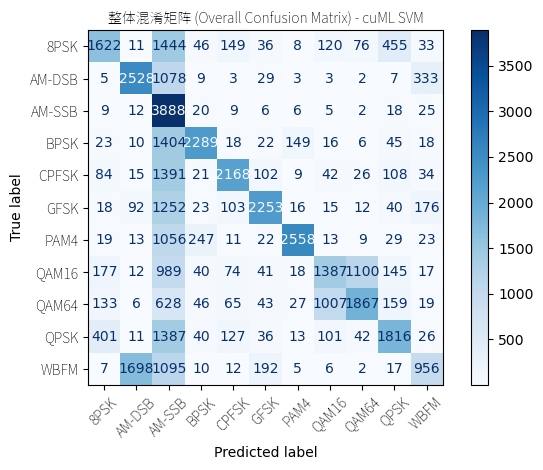

In [ ]:
# ## 8. 绘制整体混淆矩阵 (调用 utils)

# +
# 检查整体混淆矩阵数据是否存在
if 'conf_matrix_overall_np' in locals() and conf_matrix_overall_np is not None:
    print("\n绘制整体混淆矩阵...")
    plotting_utils.plot_overall_cm(
        conf_matrix_overall_np, # 输入应为 NumPy 混淆矩阵
        mods,                   # 调制类型名称列表
        model_name=MODEL_NAME,  # 使用之前定义的模型名称
        font_filename=FONT_FILENAME,
        font_subdir=FONT_SUBDIR
    )
    plt.show() # 显式调用 show() 以确保在不同环境中都能显示图像
else:
    print("\n错误：整体混淆矩阵数据不存在，无法绘图。")
# -


绘制不同 SNR 下的混淆矩阵...
绘图：成功加载字体属性: Noto Sans SC (来自 /home/thunder032/RADIOML/RadioML2016.10a_SVM/fonts/NotoSansSC-VariableFont_wght.ttf)
绘制包含所有 SNR 的网格混淆矩阵图...


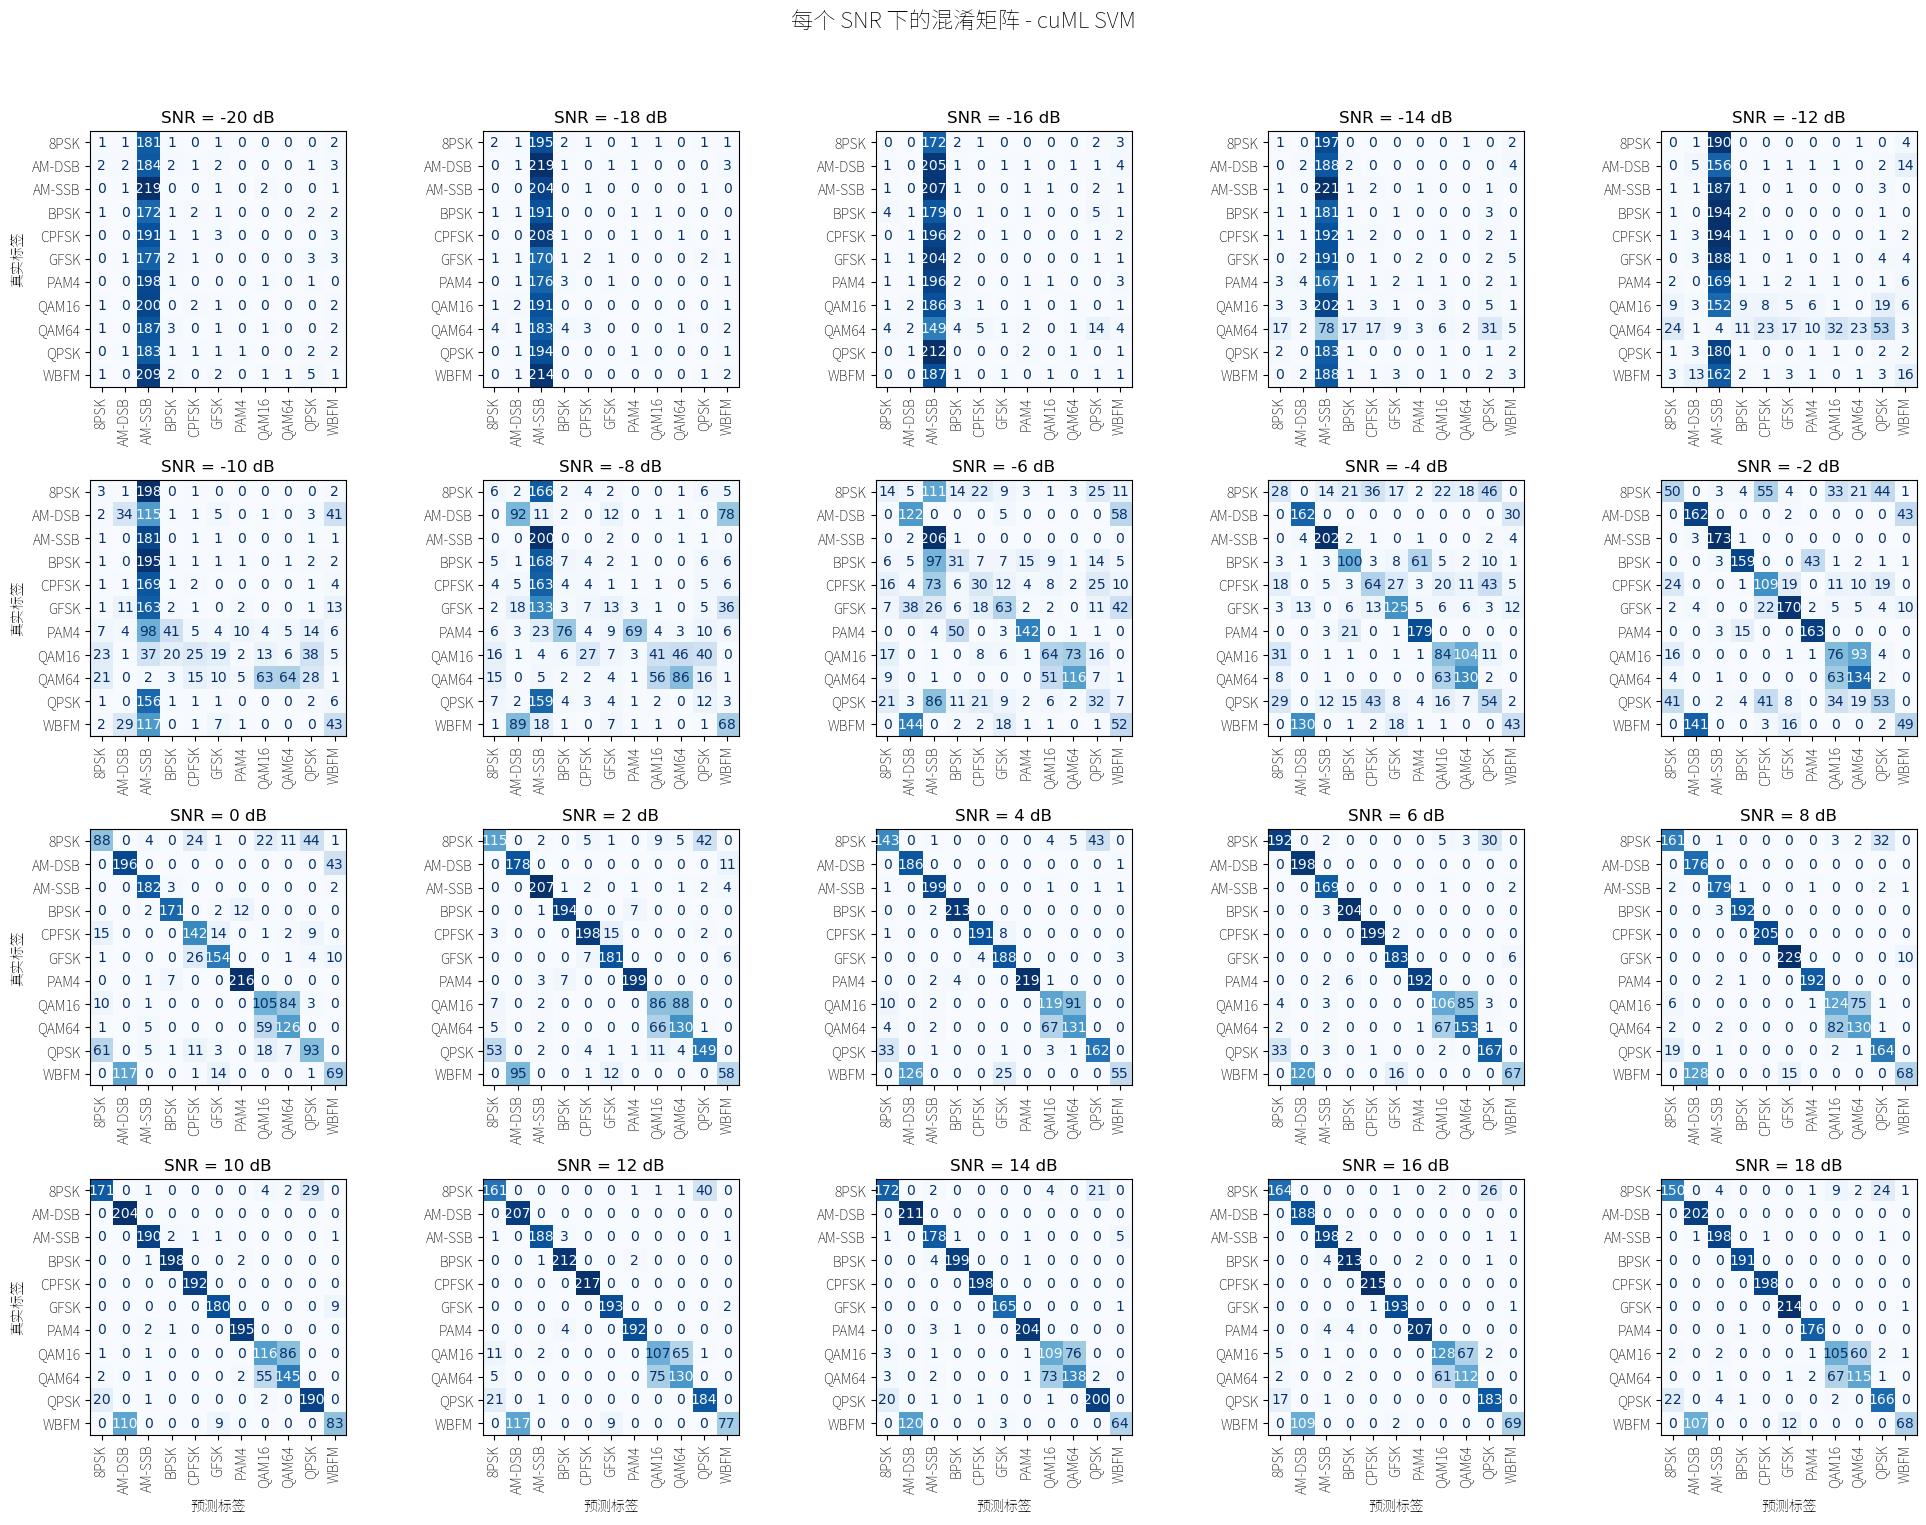

网格混淆矩阵图绘制完成。

绘制每个 SNR 的单独混淆矩阵图...
单独图像将保存到 'snr_cm_plots_cuML_SVM' 目录。
已保存: snr_cm_plots_cuML_SVM/cm_cuML_SVM_snr_neg20dB.png
已保存: snr_cm_plots_cuML_SVM/cm_cuML_SVM_snr_neg18dB.png
已保存: snr_cm_plots_cuML_SVM/cm_cuML_SVM_snr_neg16dB.png
已保存: snr_cm_plots_cuML_SVM/cm_cuML_SVM_snr_neg14dB.png
已保存: snr_cm_plots_cuML_SVM/cm_cuML_SVM_snr_neg12dB.png
已保存: snr_cm_plots_cuML_SVM/cm_cuML_SVM_snr_neg10dB.png
已保存: snr_cm_plots_cuML_SVM/cm_cuML_SVM_snr_neg8dB.png
已保存: snr_cm_plots_cuML_SVM/cm_cuML_SVM_snr_neg6dB.png
已保存: snr_cm_plots_cuML_SVM/cm_cuML_SVM_snr_neg4dB.png
已保存: snr_cm_plots_cuML_SVM/cm_cuML_SVM_snr_neg2dB.png
已保存: snr_cm_plots_cuML_SVM/cm_cuML_SVM_snr_0dB.png
已保存: snr_cm_plots_cuML_SVM/cm_cuML_SVM_snr_2dB.png
已保存: snr_cm_plots_cuML_SVM/cm_cuML_SVM_snr_4dB.png
已保存: snr_cm_plots_cuML_SVM/cm_cuML_SVM_snr_6dB.png
已保存: snr_cm_plots_cuML_SVM/cm_cuML_SVM_snr_8dB.png
已保存: snr_cm_plots_cuML_SVM/cm_cuML_SVM_snr_10dB.png
已保存: snr_cm_plots_cuML_SVM/cm_cuML_SVM_snr_12dB.png
已保存: snr_cm_plots_cuML_

In [ ]:
# ## 9. 绘制每个 SNR 下的混淆矩阵 (调用 utils)

# +
# 检查按 SNR 分组的混淆矩阵数据是否存在
if 'snr_conf_matrix_np_dict' in locals() and snr_conf_matrix_np_dict:
    print("\n绘制不同 SNR 下的混淆矩阵...")
    plotting_utils.plot_snr_cms(
        snr_conf_matrix_np_dict, # 输入为 SNR 到 NumPy 混淆矩阵的字典
        mods,                    # 调制类型名称列表
        model_name=MODEL_NAME,   # 模型名称
        font_filename=FONT_FILENAME,
        font_subdir=FONT_SUBDIR,
        save_individual_figs=True, # 保存每个 SNR 的单独图像
        individual_fig_dir=f"snr_cm_plots_{MODEL_NAME.replace(' ', '_')}" # 指定保存目录
    )
    plt.show() # 显式调用 show() 以确保网格图显示
else:
    print("\n错误：按 SNR 的混淆矩阵数据不存在，无法绘图。")
# -


绘制 Accuracy vs. SNR 曲线...
绘图：成功加载字体属性: Noto Sans SC (来自 /home/thunder032/RADIOML/RadioML2016.10a_SVM/fonts/NotoSansSC-VariableFont_wght.ttf)


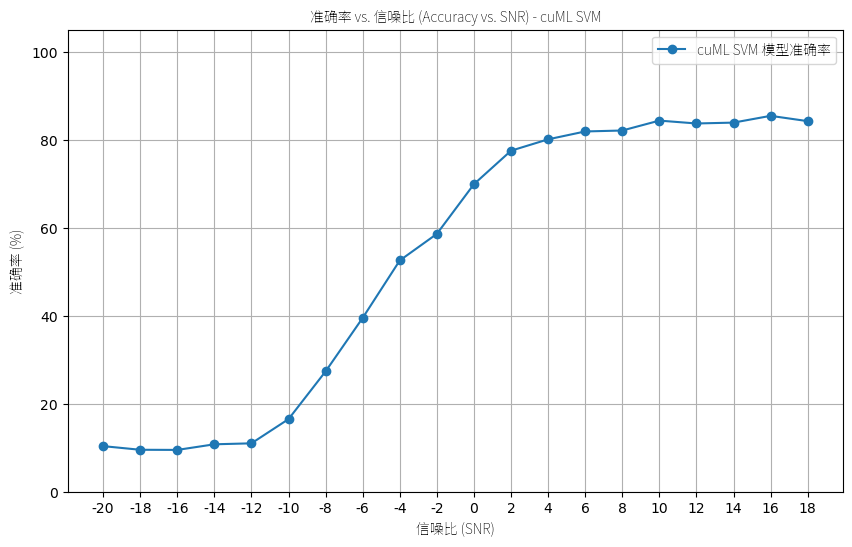

In [ ]:
# ## 10. 绘制 Accuracy vs. SNR 曲线 (调用 utils)

# +
# 检查按 SNR 分组的准确率数据是否存在
if 'snr_acc_percent' in locals() and snr_acc_percent:
    print("\n绘制 Accuracy vs. SNR 曲线...")
    plotting_utils.plot_acc_vs_snr(
        snr_acc_percent,        # 输入为 SNR 到准确率(百分比)的字典
        model_name=MODEL_NAME,  # 模型名称
        font_filename=FONT_FILENAME,
        font_subdir=FONT_SUBDIR
    )
    plt.show() # 显式调用 show()
else:
    print("\n错误：SNR 准确率数据不存在，无法绘图。")
# -

In [ ]:
# ## 11. 总结与结论 (可选)
#
# 在此总结手动选择参数下 SVM 模型的性能。
# - 整体准确率: [从模块 6 输出获取]
# - 高信噪比下准确率: [从模块 7 或图 10 获取]
# - 低信噪比下准确率: [从模块 7 或图 10 获取]
# - 主要混淆的类别: [从模块 8 或 9 的混淆矩阵图分析]
# - 训练/预测时间: [从模块 4 和 5 输出获取]
#
# 可以与后续其他模型（如 RF, CNN 等）的性能进行对比。
#
# --- End of Notebook ---